In [1]:
import sys

from IPython.display import display
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import proplot as plot
from pprint import pprint

sys.path.append('/Users/46h/Research/code/')
from accphys.tools import utils
from accphys.tools import beam_analysis as ba 
from accphys.tools import plotting as myplt

sys.path.append('/Users/46h/Research/code/accphys/pyorbit/measurement/')
from data_analysis import reconstruct

In [2]:
plot.rc['grid.alpha'] = 0.04
plot.rc['figure.facecolor'] = 'white'

# RTBT emittance measurement data analysis 
> 05.31.2021

## Introduction 

### Method summary

Our goal is to reconstruct the transverse beam covariance matrix at position $s = s_0$:
<br>
<br>
$$
\Sigma_{0} = \begin{bmatrix}
    \langle{x^2}\rangle & \langle{xx'}\rangle & \langle{xy}\rangle & \langle{xy'}\rangle \\
    \langle{xx'}\rangle & \langle{{x'}^2}\rangle & \langle{yx'}\rangle & \langle{x'y'}\rangle \\
    \langle{xy}\rangle & \langle{yx'}\rangle & \langle{y^2}\rangle & \langle{yy'}\rangle \\
    \langle{xy'}\rangle & \langle{x'y'}\rangle & \langle{yy'}\rangle & \langle{{y'}^2}\rangle
\end{bmatrix}.
$$

We are taking $s_0$ to be the start of the RTBT. To do this, a set of $n$ wire-scanners can be placed at positions $\{s_i\} > s_0$ with $i = 1, ..., n$. A single measurement from the $i$th wire-scanner will produce the real-space moments of the beam at $s_i$: $\langle{x^2}\rangle_{i}$, $\langle{y^2}\rangle_{i}$, and $\langle{xy}\rangle_{i}$. Without space charge, the transfer matrix $M_{s_0 \rightarrow s_i} = M_i$ is known. The moments at $s_0$ are then related to those at $s_i$ by

$$\Sigma_i = M_i \Sigma_{0} {M_i}^T.$$ This gives three equations relating the measured moments at $s_i$ and the unknown moments at $s_0$: <br>

$$
\begin{align}
    \langle{x^2}\rangle_i &= 
        m_{11}^2\langle{x^2}\rangle_{0} 
      + m_{12}^2\langle{x'^2}\rangle_{0} 
      + 2m_{11}m_{22}\langle{xx'}\rangle_{0} ,\\
    \langle{y^2}\rangle_i &= 
        m_{33}^2\langle{y^2}\rangle_{0} 
      + m_{34}^2\langle{y'^2}\rangle_{0} 
      + 2m_{33}m_{34}\langle{yy'}\rangle_{0} ,\\
    \langle{xy}\rangle_i &= 
        m_{11}m_{33}\langle{xy}\rangle_{0} 
      + m_{12}m_{33}\langle{yx'}\rangle_{0} 
      + m_{11}m_{34}\langle{xy'}\rangle_{0} 
      + m_{12}m_{34}\langle{x'y'}\rangle_{0} ,
\end{align}
$$

where $m_{jk}$ are the elements of the transfer matrix. Taking 3 measurements with different optics settings between $s_0$ and $s_i$ (and therefore different transfer matrices) gives the 10 equations necessary to solve for $\Sigma_0$; however, real measurements will be noisy, so it is better to take more measurements if possible. Given $N$ measurements, we can form a $3N \times 1$ observation array $\mathbf{b}$ from the measured moments and a $3N \times 10$ coefficient array $\mathbf{A}$ from the transfer matrix such that

$$\begin{align} \mathbf{A \sigma}_0 = \mathbf{b},\end{align}$$ 

where $\mathbf{\sigma}_0$ is a $10 \times 1$ vector of the moments at $s_0$. There are 5 wire-scanners in the RTBT which operate simultaneously, so using all of them increases the size of the coefficient array to $15N \times 10$. We then choose $\mathbf{\sigma}_0$ such that $|\mathbf{A\sigma}_0 - \mathbf{b}|^2$ is minimized. 

### Details of this run

Regular production settings were used, i.e., the beam should be somewhat square in real space and have no cross-plane correlations. Thus, the four-dimensional emittance is expected to be the product of the two-dimensional apparent emittances. I don't remember the number of turns that were accumulated — maybe around 250. 

The phase advances were measured from the start of the RTBT to the last wire-scanner — WS24. Ideally, these phase advances are varied linearly in a 180 degree range centered on the default phase advances. We chose to cover this range in 12 steps; however, we didn't have time to do all 12 measurements. Therefore, instead of [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], we only did [0, 1, 3, 7, 11]. This should still be sufficient to reconstruct the covariance matrix. We also took a measurement at the default machine settings, but we can't use this in the reconstruction: I didn't record the field settings and can't get them now because the machine is down.

In [3]:
scan_indices = [0, 1, 3, 7, 11]

## View parameters at each scan index 

In [4]:
phases = np.loadtxt('phases.dat')
twiss_list = [np.loadtxt('./twiss_{}.dat'.format(i)) 
              for i in scan_indices + ['default']]

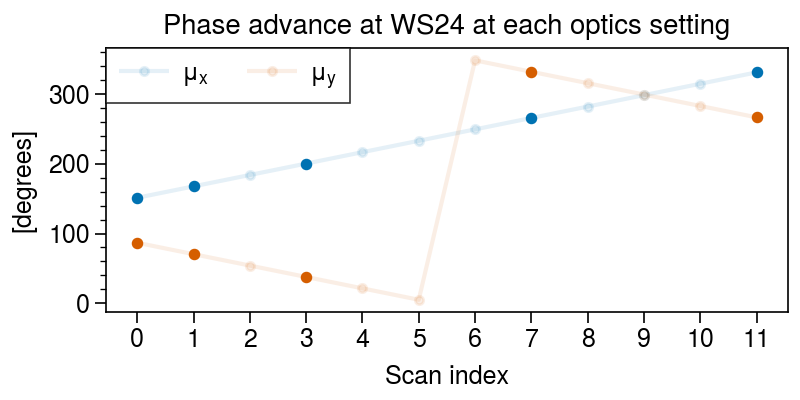

In [5]:
fig, ax = plot.subplots(figsize=(4, 2))
ax.plot(np.degrees(phases[:, 0]), marker='.', alpha=0.1)
ax.plot(np.degrees(phases[:, 1]), marker='.', alpha=0.1)
ax.format(cycle='colorblind')
ax.scatter(scan_indices, np.degrees(phases[scan_indices, 0]), marker='.', s=50)
ax.scatter(scan_indices, np.degrees(phases[scan_indices, 1]), marker='.', s=50)
ax.legend(labels=[r'$\mu_x$', r'$\mu_y$']);
ax.format(xlabel='Scan index', ylabel='[degrees]', xticks=range(12), xtickminor=False,
          title='Phase advance at WS24 at each optics setting', grid=False)

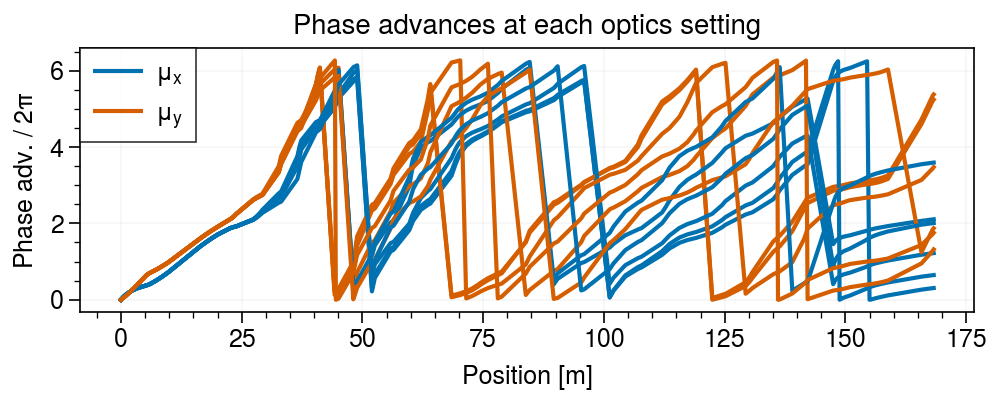

In [6]:
fig, ax = plot.subplots(figsize=(5, 2))
for twiss in twiss_list:
    pos, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss.T
    ax.format(cycle='colorblind')
    ax.plot(pos, mu_x)
    ax.plot(pos, mu_y)
ax.legend(labels=[r'$\mu_x$', r'$\mu_y$'], ncols=1);
ax.format(ylabel=r'Phase adv. / 2$\pi$', xlabel='Position [m]',
          title='Phase advances at each optics setting')

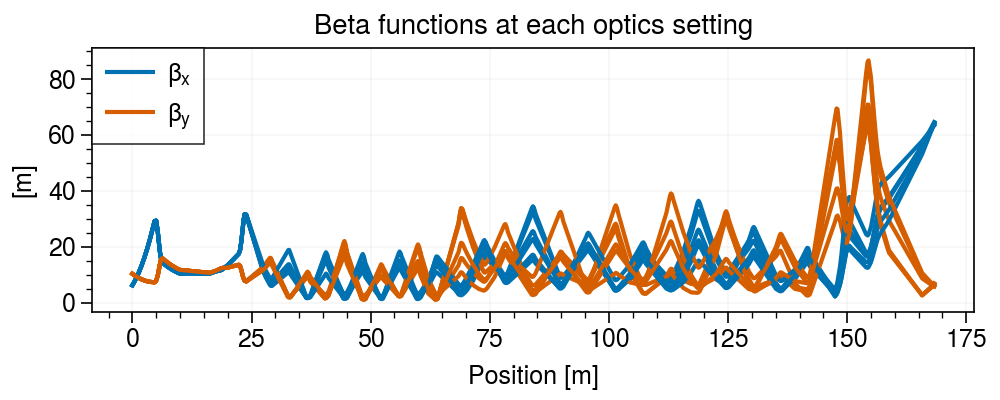

In [7]:
fig, ax = plot.subplots(figsize=(5, 2))
for twiss in twiss_list:
    pos, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss.T
    ax.format(cycle='colorblind')
    ax.plot(pos, beta_x)
    ax.plot(pos, beta_y)
ax.legend(labels=[r'$\beta_x$', r'$\beta_y$'], ncols=1);
ax.format(ylabel='[m]', xlabel='Position [m]', 
          title='Beta functions at each optics setting')

## Process wire-scanner data 

### Collect files 

In [8]:
filenames_and_indices = []
for filename in utils.list_files('./', join=False):
    if not filename.startswith('Wire') or 'default' in filename:
        continue
    index = int(filename.split('.pta')[0].split('_')[-1])
    filenames_and_indices.append([filename, index])
filenames_and_indices = sorted(filenames_and_indices, key=lambda item: item[1])
filenames = [filename for (filename, index) in filenames_and_indices]
indices = [index for (filename, index) in filenames_and_indices]

We also took a measurement when the machine was at its default setting, but didn't save the transfer matrix. Add this measurement data for now.

In [9]:
filenames.append('WireAnalysisFmt-2021.05.31_21.08.18_default.pta.txt')

In [10]:
pprint(filenames)

['WireAnalysisFmt-2021.05.31_21.34.38_0.pta.txt',
 'WireAnalysisFmt-2021.05.31_21.23.35_1.pta.txt',
 'WireAnalysisFmt-2021.05.31_21.40.23_3.pta.txt',
 'WireAnalysisFmt-2021.05.31_21.46.32_7.pta.txt',
 'WireAnalysisFmt-2021.05.31_21.52.00_11.pta.txt',
 'WireAnalysisFmt-2021.05.31_21.08.18_default.pta.txt']


### Extract profile data

Each profile measurement contains a series of positions $\{x_{i}\}$ and signal amplitudes $\{f(x_i)\}$ with $i$ = 1, ..., $N$. The Profile Tools and Analysis (PTA) application in OpenXAL actually analyzes the signals for us.

In [11]:
class Profile:
    """Class to store profile measurement data.
    
    Attributes
    ----------
    data : Pandas DataFrame
        Contains positions ('xpos', 'ypos', 'upos'), raw signal amplitudes 
        ('xraw', 'yraw', 'uraw'), and Gaussian fit amplitudes ('xfit', 'yfit',
        'ufit'). For some reason the bi-modal Gaussian isn't written to the
        file.
    params : Pandas DataFrame
        Statistical signal parameters. The first column indicates the 
        parameter name ('Area', 'Ampl', 'Mean', 'Sigma', 'Offset', 'Slope'). 
        The rest of the columns indicate the wire and type of data ('xfit', 
        'xraw', 'yfit', 'yraw', 'ufit', 'uraw'). 
    """
    def __init__(self, data, params):
        self.data, self.params = data, params
        
    def get_param(self, name, dim='x', dtype='rms'):
        if name not in ['Area', 'Ampl', 'Mean', 'Sigma', 'Offset', 'Slope']:
            return
        if dtype not in ['rms', 'fit']:
            return 
        rows = self.params.name == name
        col = dim + dtype
        return float(self.params.loc[rows, col])

In [12]:
def line_to_float_list(line):
    """Convert string to list of floats.
    
    '1 2 3' -> [1.0, 2.0, 3.0])
    """
    return [float(string) for string in line.split()] 

def lines_to_float_array(lines):
    """Convert list of strings to ndarray of floats.
    
    ['1 2 3', '4 5 6'] -> array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    """
    return np.array([line_to_float_list(line) for line in lines])

def read_pta(filename):
    """Return dictionary of Profiles from a PTA output file.
    
    The dictionary keys are the wire-scanner names.
    """
    # Collect lines corresponding to each wire-scanner
    file = open(filename, 'r')
    lines, ws_id = dict(), None
    for line in file:
        line = line.rstrip()
        if line.startswith('RTBT_Diag'):
            ws_id = line.split(':')[-1]
            continue
        if ws_id:
            lines.setdefault(ws_id, []).append(line)
    file.close()

    # Read the lines
    profiles = dict()
    for ws_id in sorted(list(lines)):
        # Split lines into three sections: params, signal, and fit. There is one
        # blank line after each section.
        lines_params, lines_signal, lines_fit = utils.split_list(lines[ws_id], '')[:3]

        # Remove headers and dashed lines beneath headers.
        lines_params = lines_params[2:]
        lines_signal = lines_signal[2:]
        lines_fit = lines_fit[2:]     

        # The columns of the following array are ['pos', 'yraw', 'uraw', 'xraw', 
        # 'xpos', 'ypos', 'upos']. (NOTE: This is not the order that is written
        # in the file header; I had to go into the source code to find the 
        # correct order). The 'pos' and 'upos' parameters are the same: they 
        # represent the position along the diagonal scan direction. The 'xpos' 
        # and 'ypos' are the positions along the horizontal and vertical 
        # directions, respectively. Finally, 'xraw', 'yraw', and 'uraw' give the 
        # raw signal amplitudes at each position.
        data_arr_signal = lines_to_float_array(lines_signal)

        # This next array is the same, but it contains 'xfit', 'yfit', 'ufit', 
        # instead of 'xraw', 'yraw', 'uraw'. These are the amplitudes obtained 
        # from a Gaussian fit to the signal amplitudes.
        data_arr_fit = lines_to_float_array(lines_fit)

        # Merge the two arrays into a single DataFrame `data`. Only need to 
        # keep 'xfit', 'yfit', and 'ufit' from `data_arr_fit` since all other 
        # columns are the same as `data_arr_signal`.
        data_arr = np.hstack([data_arr_signal, data_arr_fit[:, 1:4]]) 
        columns = ['pos',
                   'yraw','uraw','xraw', # note the order
                   'xpos','ypos','upos',
                   'yfit','ufit','xfit']
        data = pd.DataFrame(data_arr, columns=columns)

        # Create DataFrame `params` containing measurement parameters. (NOTE: 
        # Again, I had the parameter order from PTA is different than what is
        # written in the output file headers.)
        param_names, param_vals = [], []
        for line in lines_params:
            strings = line.split()
            param_names.append(strings[0])
            param_vals.append([float(string) for string in strings[1:]])
        param_vals = np.array(param_vals)
        columns = ['yfit', 'yrms', 'ufit', 'urms', 'xfit', 'xrms']
        params = pd.DataFrame(param_vals, columns=columns)
        params['name'] = param_names

        # Store DataFrames in Profile object and add it to the dictionary.
        profiles[ws_id] = Profile(data, params)
        
    return profiles

In [13]:
measurements = [read_pta(filename) for filename in filenames]

In [14]:
profile = measurements[0]['WS24']
display(profile.data)
display(profile.params)

,pos,yraw,uraw,xraw,xpos,ypos,upos,yfit,ufit,xfit
0,25.0,-0.002393,-0.009375,-0.005664,17.67775,17.67775,25.0,-0.005425,-0.016155,-0.010578
1,28.0,-0.001904,-0.009229,-0.005371,19.79908,19.79908,28.0,-0.005417,-0.016044,-0.010578
2,31.0,-0.002246,-0.009961,-0.005859,21.92041,21.92041,31.0,-0.005403,-0.015826,-0.010576
3,34.0,-0.002100,-0.009521,-0.005811,24.04174,24.04174,34.0,-0.005380,-0.015418,-0.010574
4,37.0,-0.002637,-0.009277,-0.005811,26.16307,26.16307,37.0,-0.005340,-0.014677,-0.010569
...,...,...,...,...,...,...,...,...,...,...
85,280.0,-0.001953,-0.008838,-0.006006,197.99080,197.99080,280.0,-0.005434,-0.016259,-0.010579
86,283.0,-0.001807,-0.008301,-0.005273,200.11213,200.11213,283.0,-0.005434,-0.016259,-0.010579
87,286.0,-0.001416,-0.008350,-0.005518,202.23346,202.23346,286.0,-0.005434,-0.016259,-0.010579
88,289.0,-0.001416,-0.008496,-0.005908,204.35479,204.35479,289.0,-0.005434,-0.016259,-0.010579


,yfit,yrms,ufit,urms,xfit,xrms,name
0,16.756203,14.797298,18.598308,16.346290,16.161669,15.271240,Area
1,0.414684,0.426611,0.452315,0.448193,0.383273,0.387354,Ampl
2,92.189046,92.293212,92.172151,93.344580,103.489345,112.817259,Mean
3,16.120111,13.139550,16.403726,12.641842,16.822406,11.804634,Sigma
4,-0.005434,-0.002148,-0.016268,-0.009302,-0.010788,-0.005518,Offset
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Slope


### View profiles 

In [15]:
def plot_profiles(measurements, ws_ids, show_fit=False, kws_raw=None, 
                  kws_fit=None, width=8, vscale=1.4):
    if kws_raw is None:
        kws_raw = dict()
    if kws_fit is None:
        kws_fit = dict()
    kws_raw['legend'] = kws_fit['legend'] = False
    kws_raw.setdefault('marker', '.')
    kws_raw.setdefault('ms', 3)
    kws_raw.setdefault('lw', 0)
    kws_fit.setdefault('color', 'k')
    kws_fit.setdefault('alpha', 0.2)
    kws_fit.setdefault('zorder', 0)
    
    n_meas = len(measurements)
    fig, axes = plot.subplots(nrows=n_meas, ncols=3, spanx=False,
                              figsize=(width, vscale*n_meas))
    
    def _plot(opt='raw', **kws):
        for i, profiles in enumerate(measurements):
            for ws_id in ws_ids:
                profile = profiles[ws_id]
                for ax, dim in zip(axes[i, :], ['x', 'y', 'u']):
                    key1, key2 = dim + 'pos', dim + opt
                    profile.data[[key1, key2]].plot(key1, ax=ax, **kws)
        
    _plot('raw', **kws_raw)
    axes[0, -1].legend(labels=ws_ids, fontsize='small', loc=(1.02, 0), ncols=1)
    if show_fit:
        _plot('fit', **kws_fit)
        
    axes.format(ylabel='Signal', grid=False, 
                toplabels=['Horizontal', 'Vertical', 'Diagonal'],
                leftlabels=scan_indices + ['default'])
    for ax, label in zip(axes[-1, :], ['x [mm]', 'y [mm]', 'u [mm]']):
        ax.format(xlabel=label)
    for ax in axes:
        ax.grid(axis='y')
    return axes

In [16]:
ws_ids = ['WS20', 'WS21', 'WS23', 'WS24']
kws_raw = dict(legend=False, marker='.', ms=3, lw=0)
kws_fit = dict(legend=False, color='k', alpha=0.2, zorder=0)

#### Raw

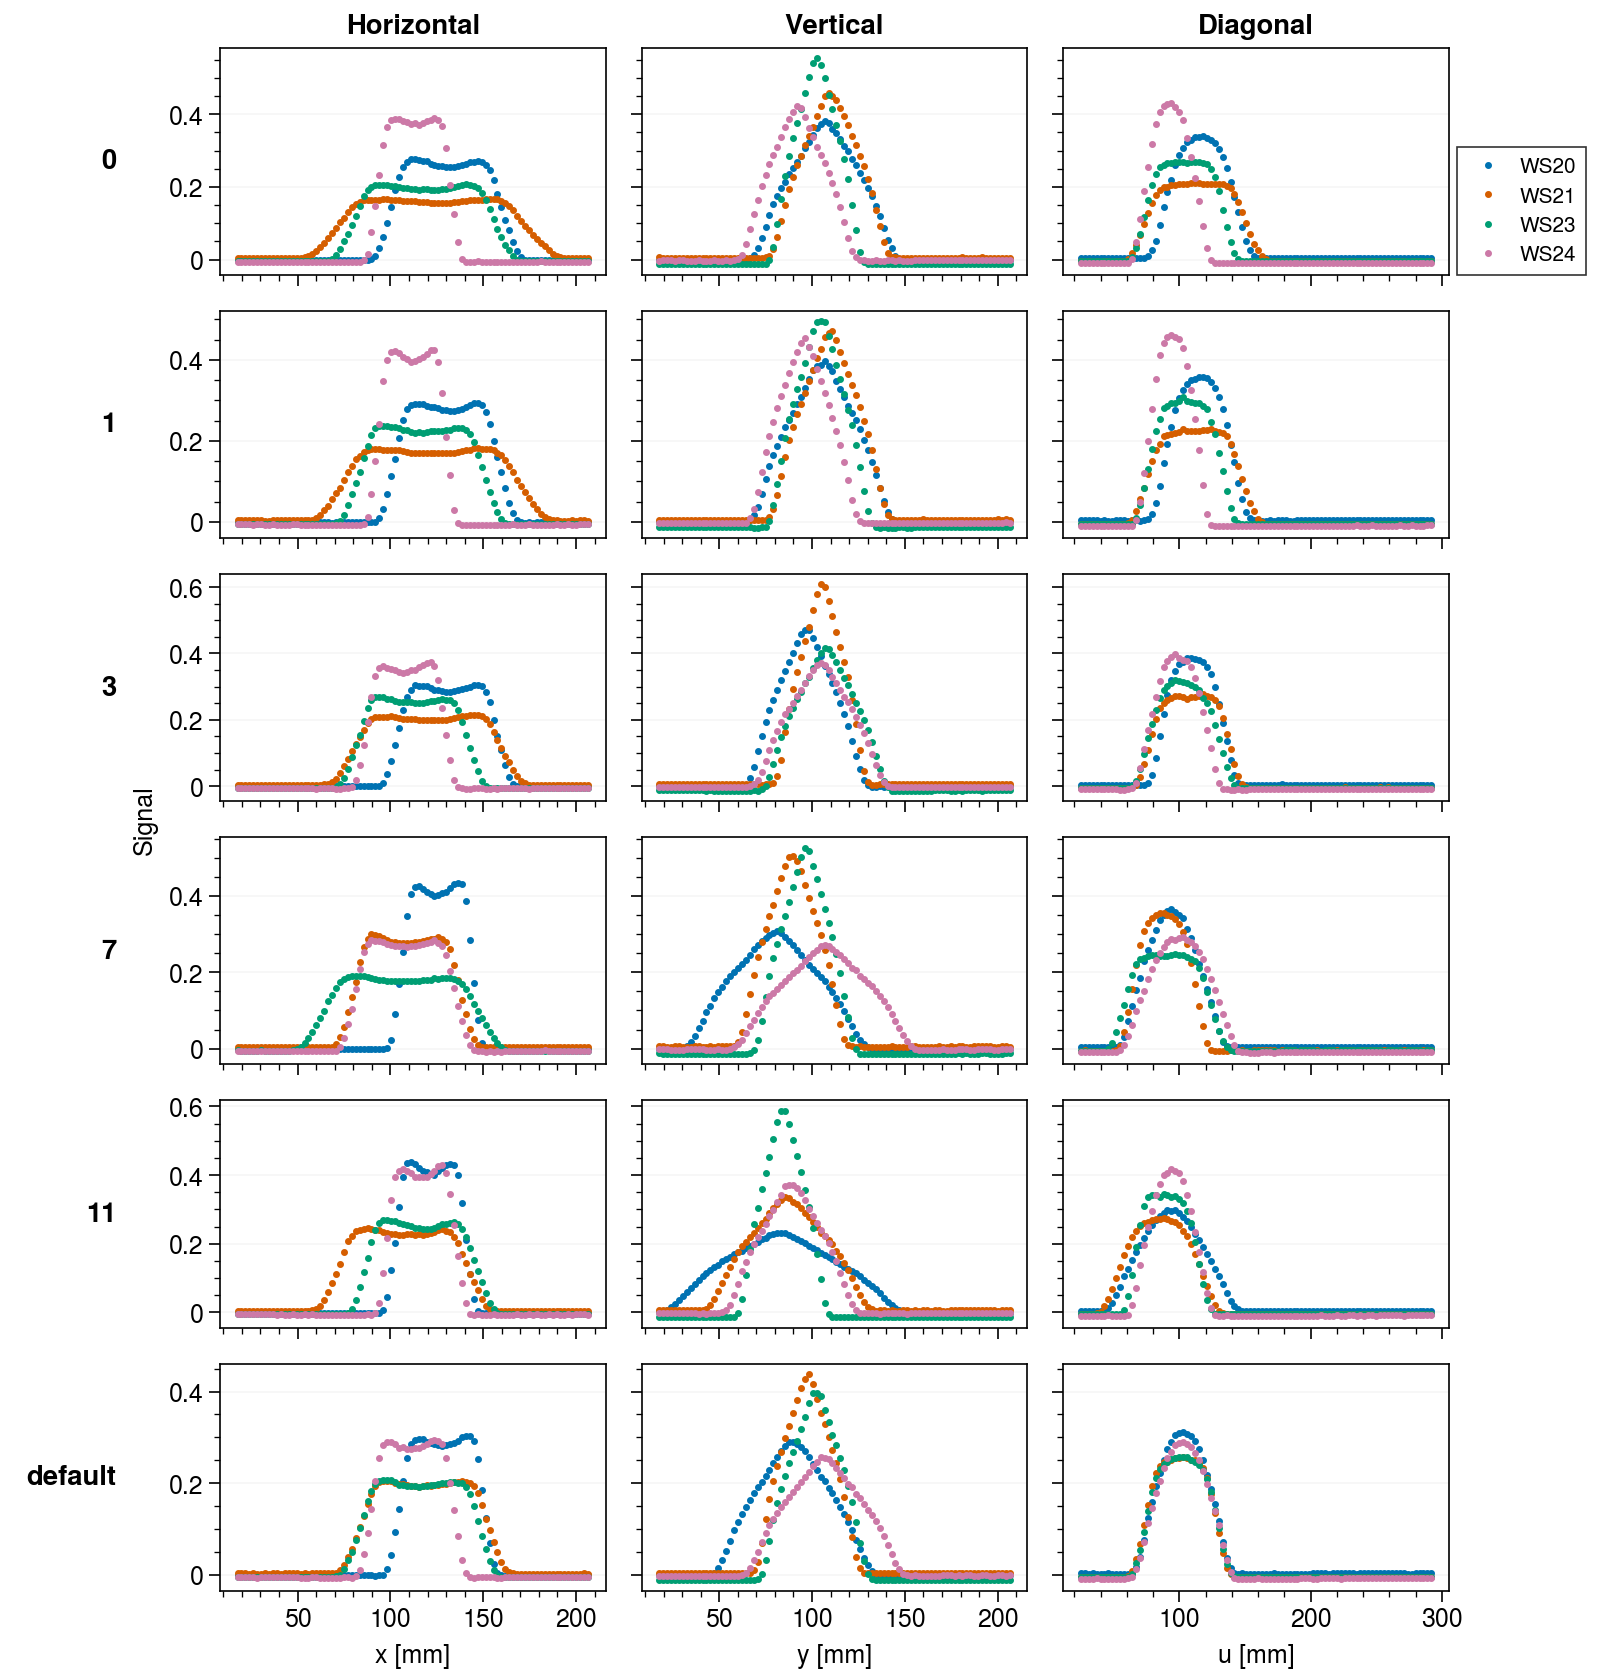

In [17]:
axes = plot_profiles(measurements, ws_ids, show_fit=False, kws_raw=kws_raw, kws_fit=kws_fit)

#### Raw + fit

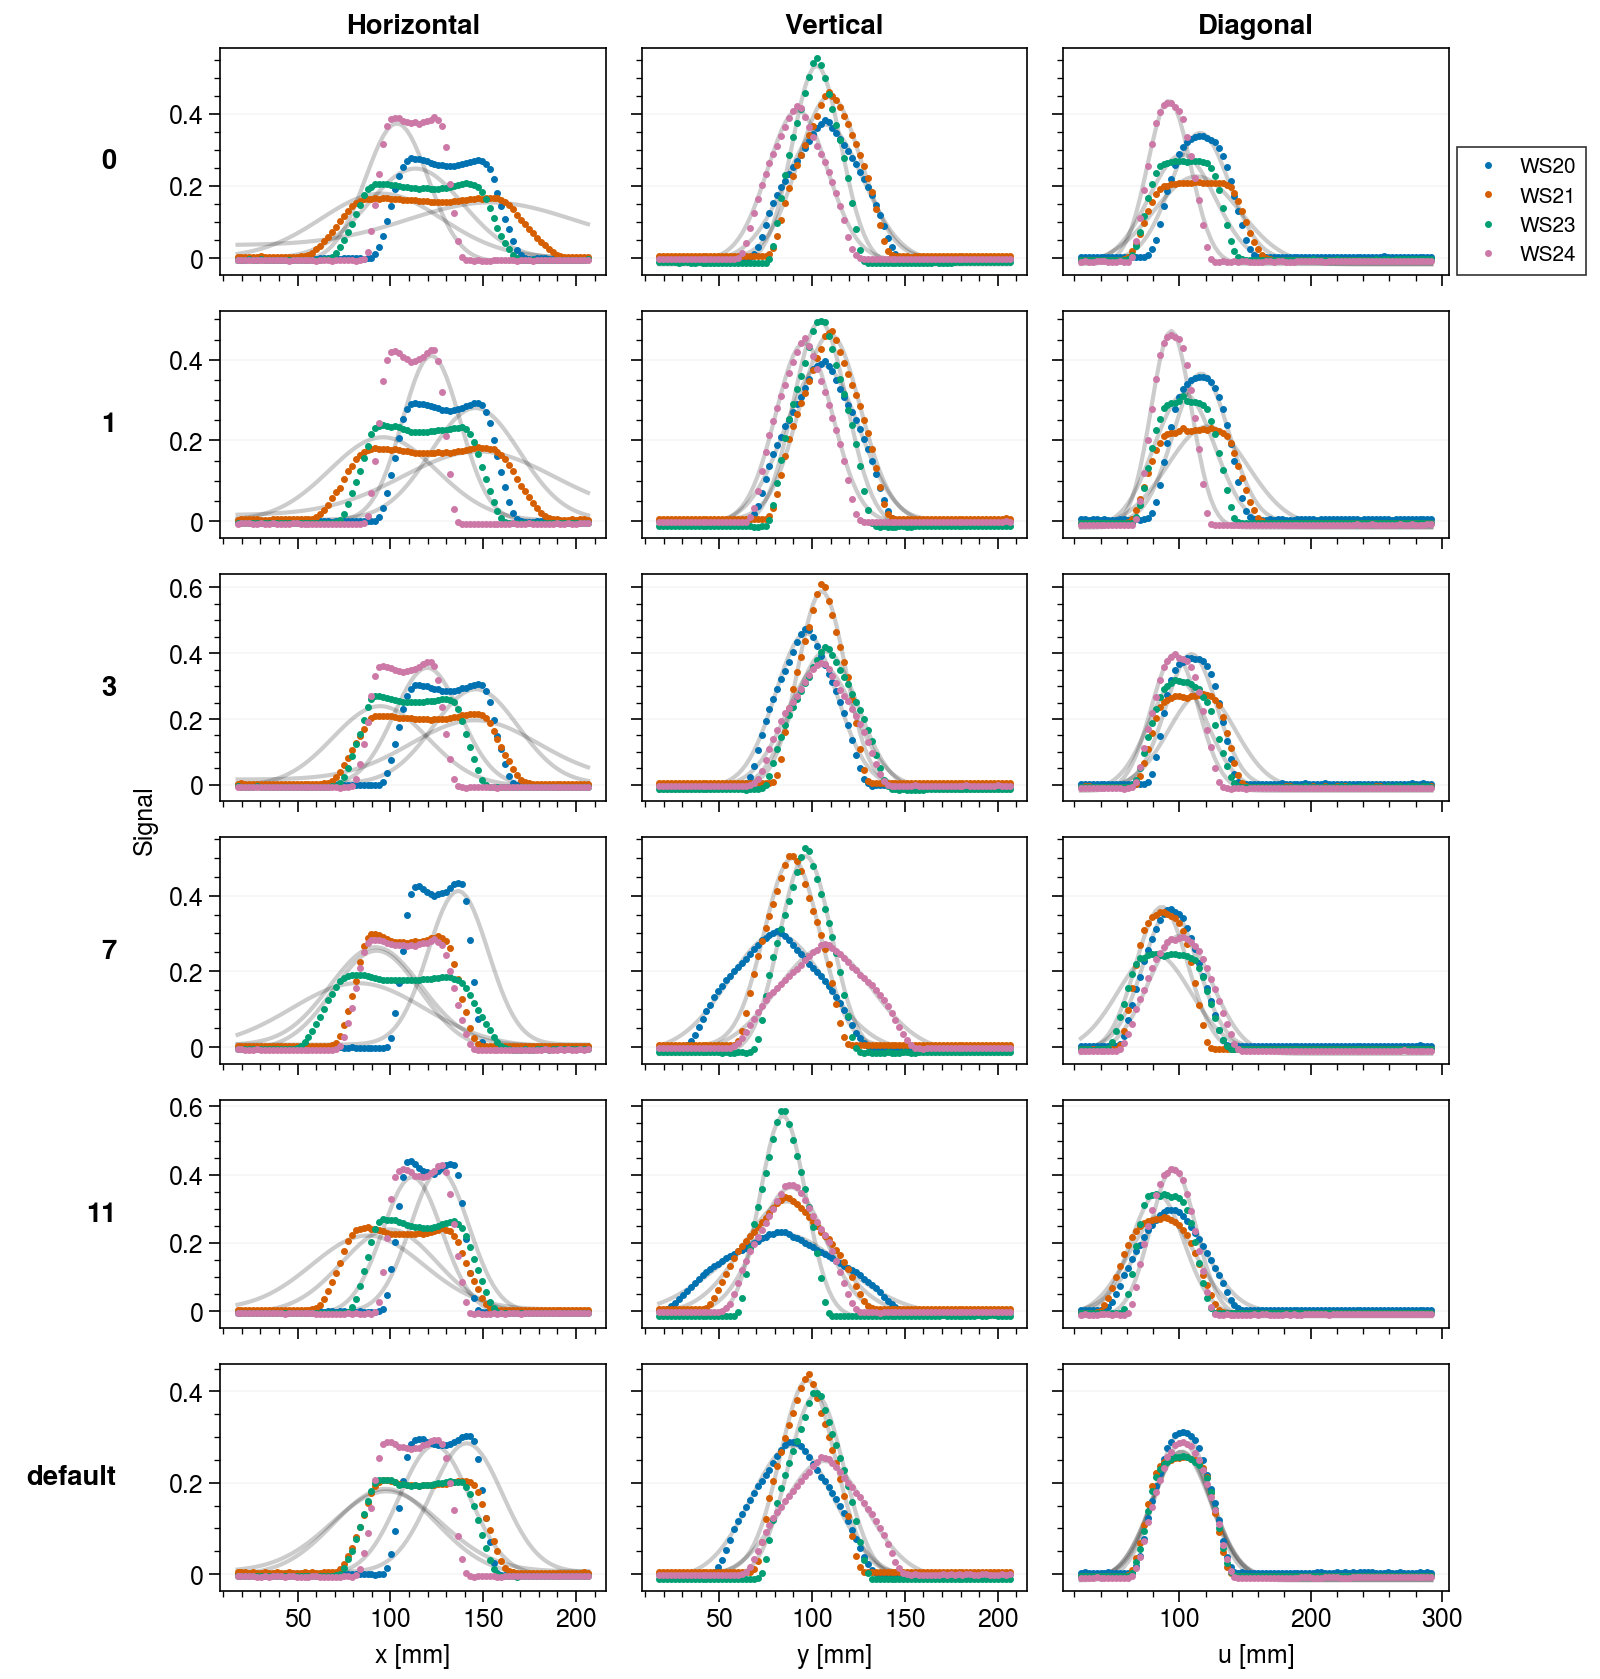

In [18]:
axes = plot_profiles(measurements, ws_ids, show_fit=True, kws_raw=kws_raw, kws_fit=kws_fit)

## Reconstruct beam moments

The covariance $\sigma_{xy}$ between *x* and *y* can be found using the beam size along the *u* axis normal to the diagonal wire.

<img src='diag_wire.png' width=200>

$$
\begin{align}
    u &= x\cos\phi + y\sin\phi \\
    \sigma_u^2 &= \langle{u^2}\rangle - \langle{u}\rangle^2 = \sigma_x^2\cos^2\phi + \sigma_y^2\sin^2\phi + 2\sigma_{xy}\sin\phi\cos\phi
\end{align}
$$

In [19]:
def get_sig_xy(sig_xx, sig_yy, sig_uu, diag_wire_angle):
    phi = np.radians(90.0) + diag_wire_angle
    sin, cos = np.sin(phi), np.cos(phi)
    sig_xy = (sig_uu - sig_xx*(cos**2) - sig_yy*(sin**2)) / (2 * sin * cos)
    return sig_xy

In [20]:
diag_wire_angle = np.radians(-45.0)

Since we didn't store the default optics, we can't use that measurement in the reconstruction. 

In [21]:
measurements = measurements[:-1]

Collect the measured beam moments at each wire-scanner. This is just for convenience.

In [22]:
moments = {ws_id: [] for ws_id in ws_ids}
for ws_id in ws_ids:
    for measurement in measurements:
        profile = measurement[ws_id]
        sig_xx = profile.get_param('Sigma', dim='x')**2
        sig_yy = profile.get_param('Sigma', dim='y')**2
        sig_uu = profile.get_param('Sigma', dim='u')**2
        sig_xy = get_sig_xy(sig_xx, sig_yy, sig_uu, diag_wire_angle)
        moments[ws_id].append([sig_xx, sig_yy, sig_xy])
    moments[ws_id] = np.array(moments[ws_id])

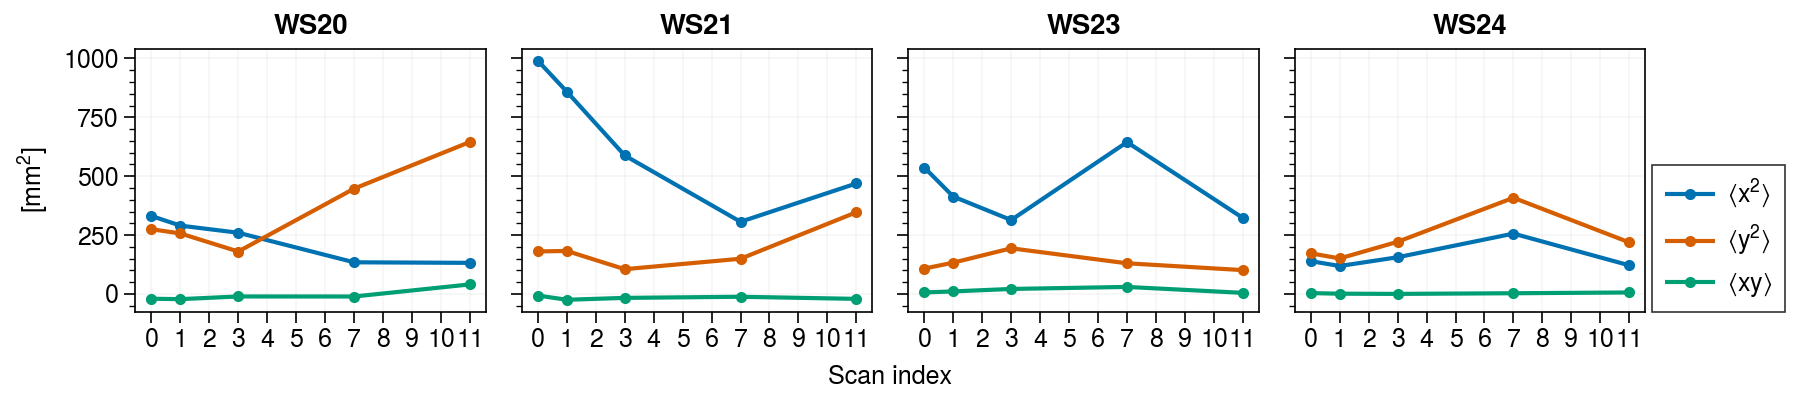

In [23]:
fig, axes = plot.subplots(ncols=4, figsize=(9, 2))
plt_kws = dict(marker='.')
for ws_id, ax in zip(ws_ids, axes):
    ax.plot(scan_indices, moments[ws_id][:, 0], **plt_kws)
    ax.plot(scan_indices, moments[ws_id][:, 1], **plt_kws)
    ax.plot(scan_indices, moments[ws_id][:, 2], **plt_kws)
axes.format(ylabel=r'[mm$^2$]', xlabel='Scan index', xtickminor=False, xticks=range(12), toplabels=ws_ids)
ax.legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'],
          ncols=1, loc=(1.02, 0));

Collect the transfer matrices at each wire-scanner as calculated by OpenXAL.

In [24]:
transfer_mats = {ws_id: [] for ws_id in ws_ids}
for ws_index, ws_id in enumerate(ws_ids):
    if ws_id == 'WS02': # didn't take data from this wire-scanner
        continue
    for scan_index in scan_indices:    
        filename = './transfer_mat_elems_{}.dat'.format(scan_index)
        matrix_elements = np.loadtxt(filename)[ws_index]
        transfer_mats[ws_id].append(matrix_elements.reshape((4, 4)))

Reconstruct the covariance matrix at the RTBT entrance.

In [25]:
moments_list, transfer_mats_list = [], []
for ws_id in ws_ids:
    moments_list.extend(moments[ws_id])
    transfer_mats_list.extend(transfer_mats[ws_id])

In [26]:
Sigma = reconstruct(transfer_mats_list, moments_list)
print('Sigma:')
print(Sigma)
alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = ba.get_twiss2D(Sigma)
eps_1, eps_2 = ba.intrinsic_emittances(Sigma)
print('eps_4D = {:.3f}'.format(np.sqrt(np.linalg.det(Sigma))))
print('eps_1, eps_2 = {:.3f}, {:.3f}'.format(eps_1, eps_2))
print('eps_x, eps_y = {:.3f}, {:.3f}'.format(eps_x, eps_y))
print('beta_x, beta_y = {:.3f}, {:.3f}'.format(beta_x, beta_y))
print('alpha_x, alpha_y = {:.3f}, {:.3f}'.format(alpha_x, alpha_y))

Sigma:
[[ 39.63851928  19.77262953  27.36060432  -0.25961891]
 [ 19.77262953  14.05982467   7.82607826  -0.1178956 ]
 [ 27.36060432   7.82607826 114.96880044 -15.22744143]
 [ -0.25961891  -0.1178956  -15.22744143   5.84503076]]
eps_4D = 218.990
eps_1, eps_2 = 22.585, 9.696
eps_x, eps_y = 12.898, 20.979
beta_x, beta_y = 3.073, 5.480
alpha_x, alpha_y = -1.533, 0.726


### Discussion 

For a long time I was getting NaN due to the XAL parameter ordering bug, so I'm happy to get real numbers. One oddity is that the reconstructed beam is much larger in the $y$ direction than in the $x$ direction. Another is that the cross-plane moments are nonzero.

In [27]:
correlation_matrix = utils.cov2corr(Sigma)
print(correlation_matrix)

[[ 1.          0.83755969  0.40530035 -0.01705628]
 [ 0.83755969  1.          0.1946544  -0.01300512]
 [ 0.40530035  0.1946544   1.         -0.58741298]
 [-0.01705628 -0.01300512 -0.58741298  1.        ]]


I propose that we use a different definition of the coupling coefficient *C*. Prat and others define it as 

$$ C = \sqrt{\frac{\varepsilon_x\varepsilon_y}{\varepsilon_1\varepsilon_2}}.$$

$C = 1$ is no coupling, while $C \gt 1$ is nonzero coupling. In our case, ideally $\varepsilon_{4D} = \sqrt{\varepsilon_1\varepsilon_2} = 0$, so it would make more sense to define

$$ C = 1 - \sqrt{\frac{\varepsilon_1\varepsilon_2}{\varepsilon_x\varepsilon_y}},$$

so that $C$ is confined to the range [0, 1] (0 if no coupling, 1 if perfect rigid rotator).

In [28]:
coupling_coeff = 1.0 - np.sqrt((eps_1 * eps_2) / (eps_x * eps_y))
print('Coupling coefficient = {}'.format(coupling_coeff))

Coupling coefficient = 0.10037522546360844


The $x$-$x'$ and $y$-$y'$ reconstructions don't depend on the diagonal wire. There's no way to check if the emittances are correct, but we can check the Twiss parameters. Below is a comparison of the rms ellipses.

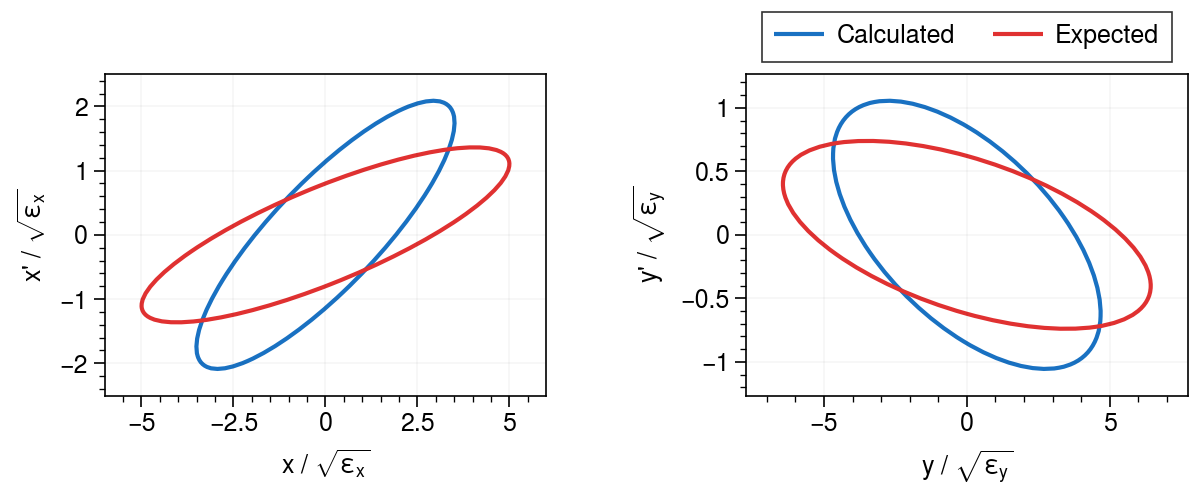

In [29]:
# Expected Twiss parameters at RTBT entrance (the reconstruction location)
alpha_x_exp = -1.378 
alpha_y_exp = 0.645
beta_x_exp = 6.243
beta_y_exp = 10.354
gamma_x_exp = (1 + alpha_x_exp**2) / beta_x_exp
gamma_y_exp = (1 + alpha_y_exp**2) / beta_y_exp

# Scale measured covariance matrix by measured x and y emittances. This just
# gives [[beta, -alpha], [-alpha, gamma]].
Sigma_scaled = np.copy(Sigma)
Sigma_scaled[:2, :2] /= eps_x
Sigma_scaled[2:, 2:] /= eps_y

# Expected covariance matrix at RTBT entrance (scaled by measured x and y emittances)
Sigma_scaled_exp = np.zeros((4, 4))
Sigma_scaled_exp[:2, :2] = [[beta_x_exp, -alpha_x_exp], [-alpha_x_exp, gamma_x_exp]]
Sigma_scaled_exp[2:, 2:] = [[beta_y_exp, -alpha_y_exp], [-alpha_y_exp, gamma_y_exp]]

# Plot epxected and calculated ellipses in x-x' and y-y' 
fig, axes = plot.subplots(ncols=2, figsize=(6, 2.5), wspace=1, sharey=False, sharex=False)
for ax, (dim1, dim2) in zip(axes, [('x', 'xp'), ('y', 'yp')]):
    angle, c1, c2 = myplt.rms_ellipse_dims(Sigma_scaled, dim1, dim2)
    angle_exp, c1_exp, c2_exp = myplt.rms_ellipse_dims(Sigma_scaled_exp, dim1, dim2)
    myplt.ellipse(ax, 2*c1, 2*c2, angle, lw=1.5, color='blue8')
    myplt.ellipse(ax, 2*c1_exp, 2*c2_exp, angle_exp, lw=1.5, color='red8')
    
# Formatting
xmax, xpmax, ymax, ypmax = 1.2 * 2 * np.sqrt(np.maximum(np.diag(Sigma_scaled), np.diag(Sigma_scaled_exp)))
axes[0].format(xlabel=r'x / $\sqrt{\varepsilon_x}$', ylabel=r"x' / $\sqrt{\varepsilon_x}$",
               xlim=(-xmax, xmax), ylim=(-xpmax, xpmax))
axes[1].format(xlabel=r'y / $\sqrt{\varepsilon_y}$', ylabel=r"y' / $\sqrt{\varepsilon_y}$",
               xlim=(-ymax, ymax), ylim=(-ypmax, ypmax))
custom_lines = [Line2D([0], [0], color='blue8'), Line2D([0], [0], color='red8')]
axes[1].legend(custom_lines, ['Calculated', 'Expected'], loc='top');

It could be worse.

### Lines 

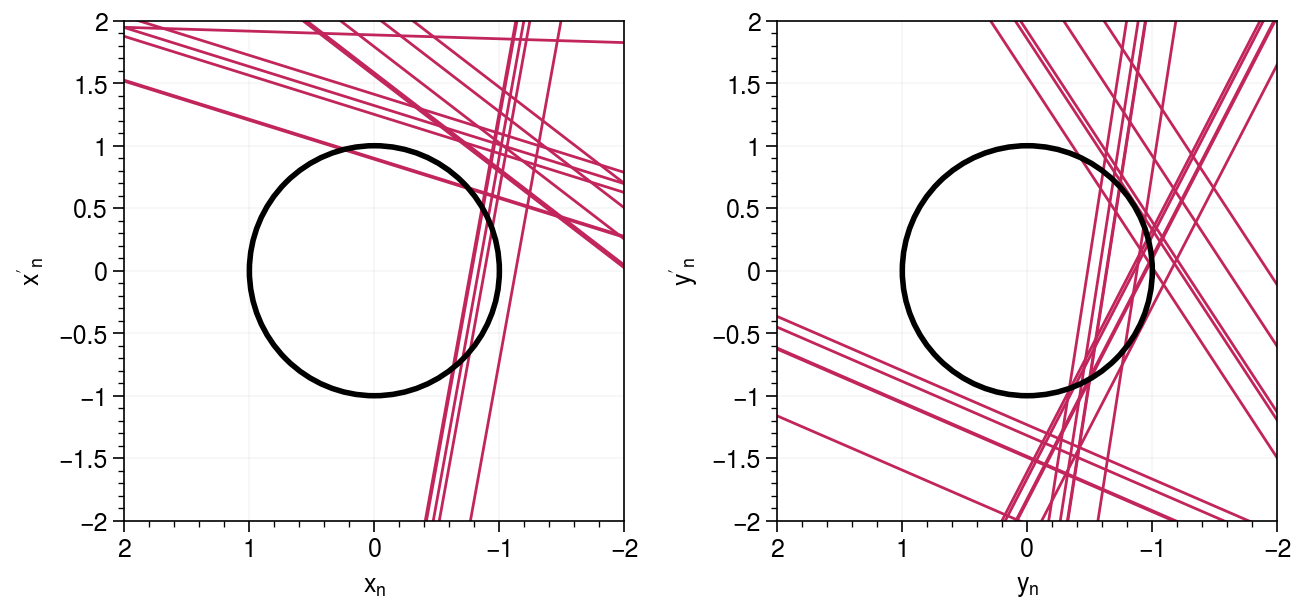

In [30]:
def V_2D(alpha, beta):
    return np.array([[beta, 0.0], [-alpha, 1.0]]) / np.sqrt(beta)

V = np.zeros((4, 4))
V[:2, :2] = V_2D(alpha_x_exp, beta_x_exp)
V[2:, 2:] = V_2D(alpha_y_exp, beta_y_exp)
Vinv = np.linalg.inv(V)
A = np.diag(np.sqrt([eps_x, eps_x, eps_y, eps_y]))
Ainv = np.linalg.inv(A)

def normalize(vec):
    return np.linalg.multi_dot([Ainv, Vinv, vec])

def get_line_points(transfer_mat, sig_xx, sig_yy, dim, upmin=-10, upmax=10):
    xrms, yrms = np.sqrt(sig_xx), np.sqrt(sig_yy)
    hpts, vpts = [], []
    for up in [upmin, upmax]:
        if dim == 'x':
            vec1 = [xrms, up, 0, 0]
            i, j = 0, 1
        elif dim == 'y':
            vec1 = [0, 0, yrms, up]
            i, j = 2, 3
        vec0 = np.matmul(np.linalg.inv(transfer_mat), vec1)
        vec0 = normalize(vec0)
        hpts.append(vec0[i])
        vpts.append(vec0[j])
    return hpts, vpts

def plot_lines(ax, transfer_mats, moments, dim='x', **kws):  
    for transfer_mat, (sig_xx, sig_yy, sig_xy) in zip(transfer_mats, moments):
        hpts, vpts = get_line_points(transfer_mat, sig_xx, sig_yy, dim)
        ax.plot(hpts, vpts, **kws)
    return ax

scale = 2
xmax = scale
ymax = scale
moments_list = np.array(moments_list)

fig, axes = plot.subplots(ncols=2, sharex=False, sharey=False)
axes.format(aspect=1)
axes[0].format(xlim=(-xmax, xmax), ylim=(-xmax, xmax), xlabel=r"$x_n$", ylabel=r"$x'_n$")
axes[1].format(xlim=(-ymax, ymax), ylim=(-ymax, ymax), xlabel=r"$y_n$", ylabel=r"$y'_n$")
myplt.ellipse(axes[0], 1, 1, lw=2, zorder=999)
myplt.ellipse(axes[1], 1, 1, lw=2, zorder=999)

nscans = len(transfer_mats_list)
kws = dict(color='pink8', lw=1)
plot_lines(axes[0], transfer_mats_list, moments_list, 'x', **kws);
plot_lines(axes[1], transfer_mats_list, moments_list, 'y', **kws);

## Sanity checks 

### Estimated means and variances

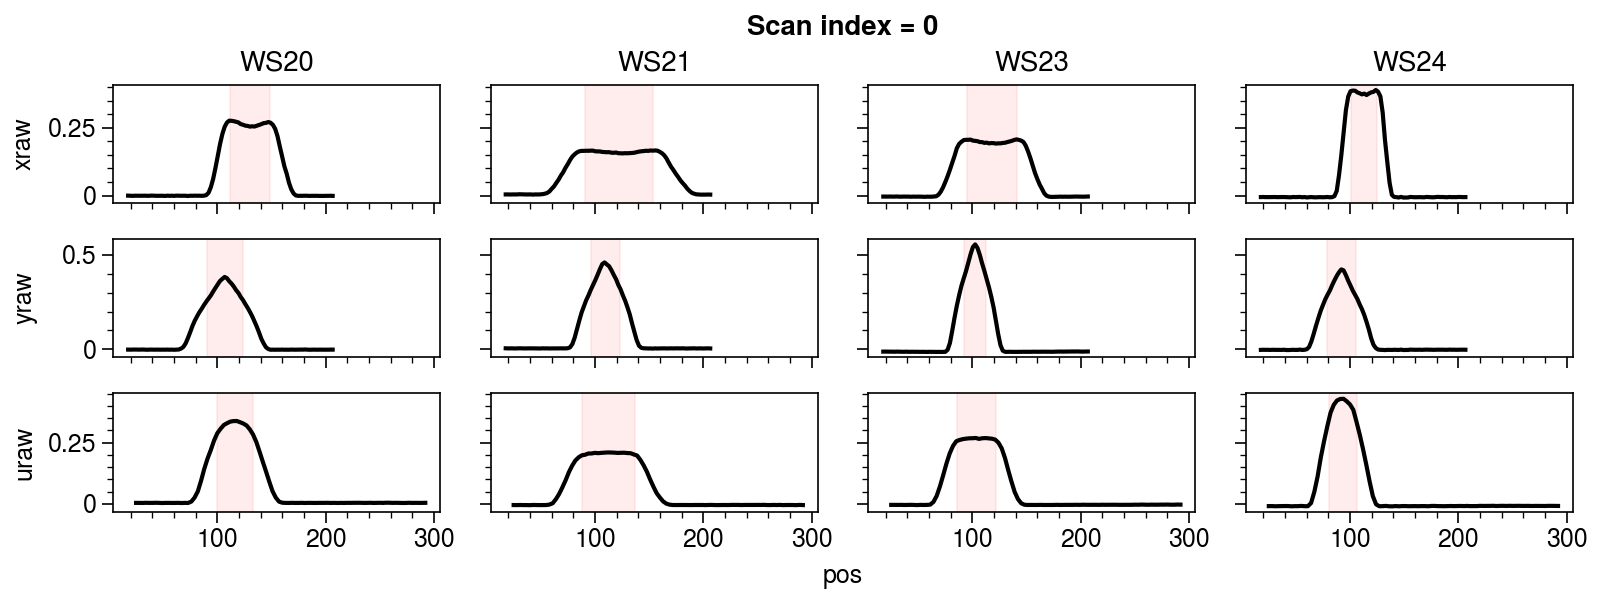

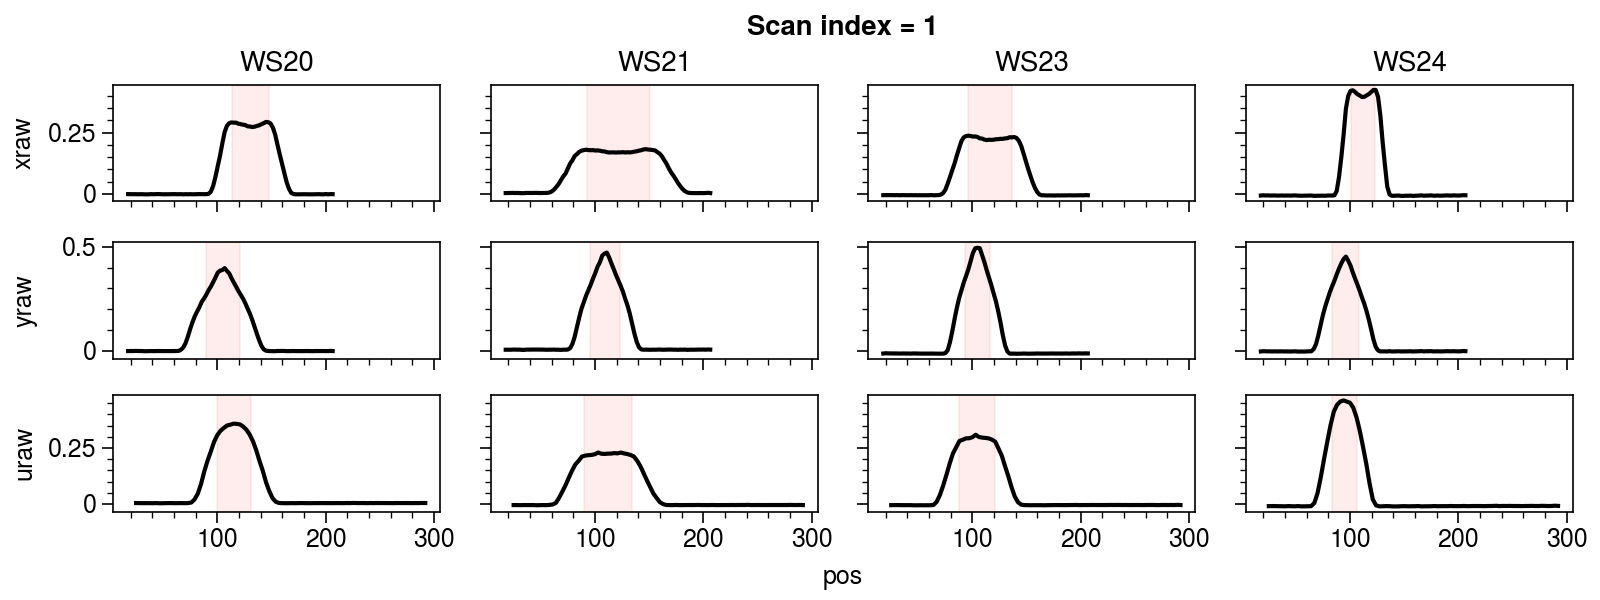

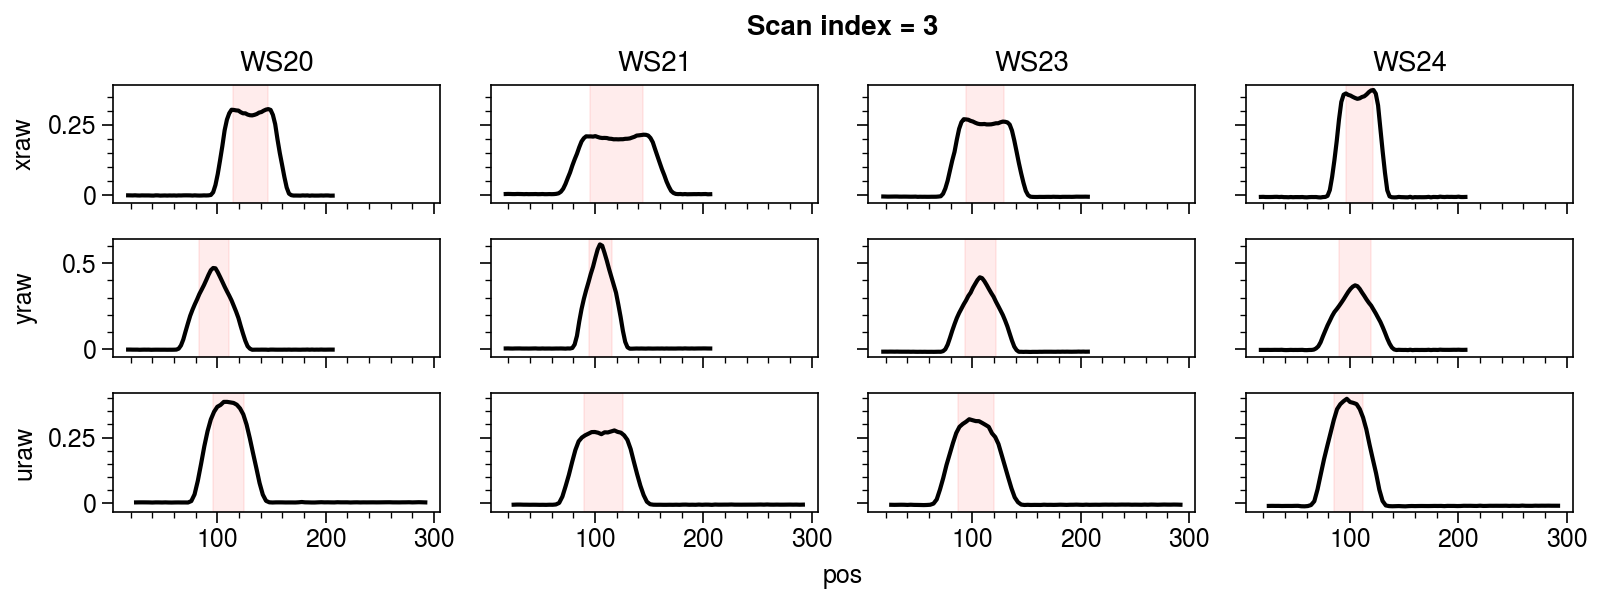

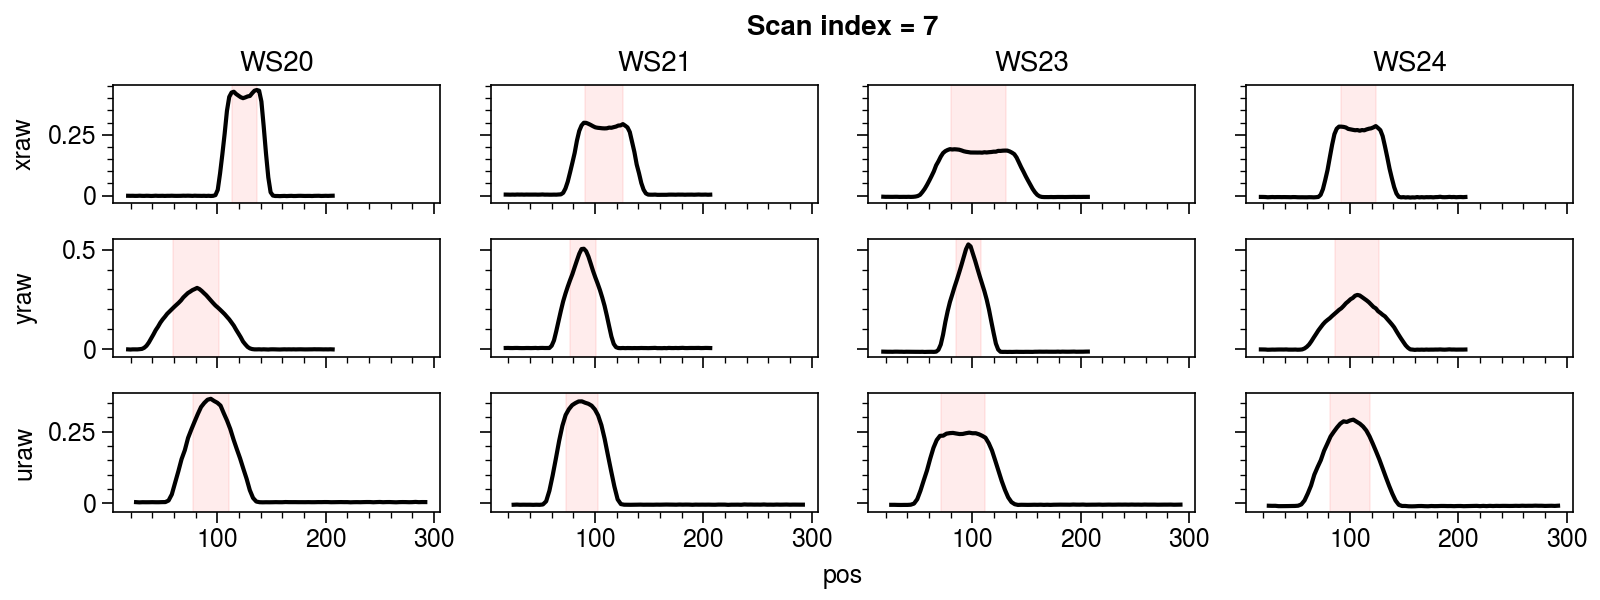

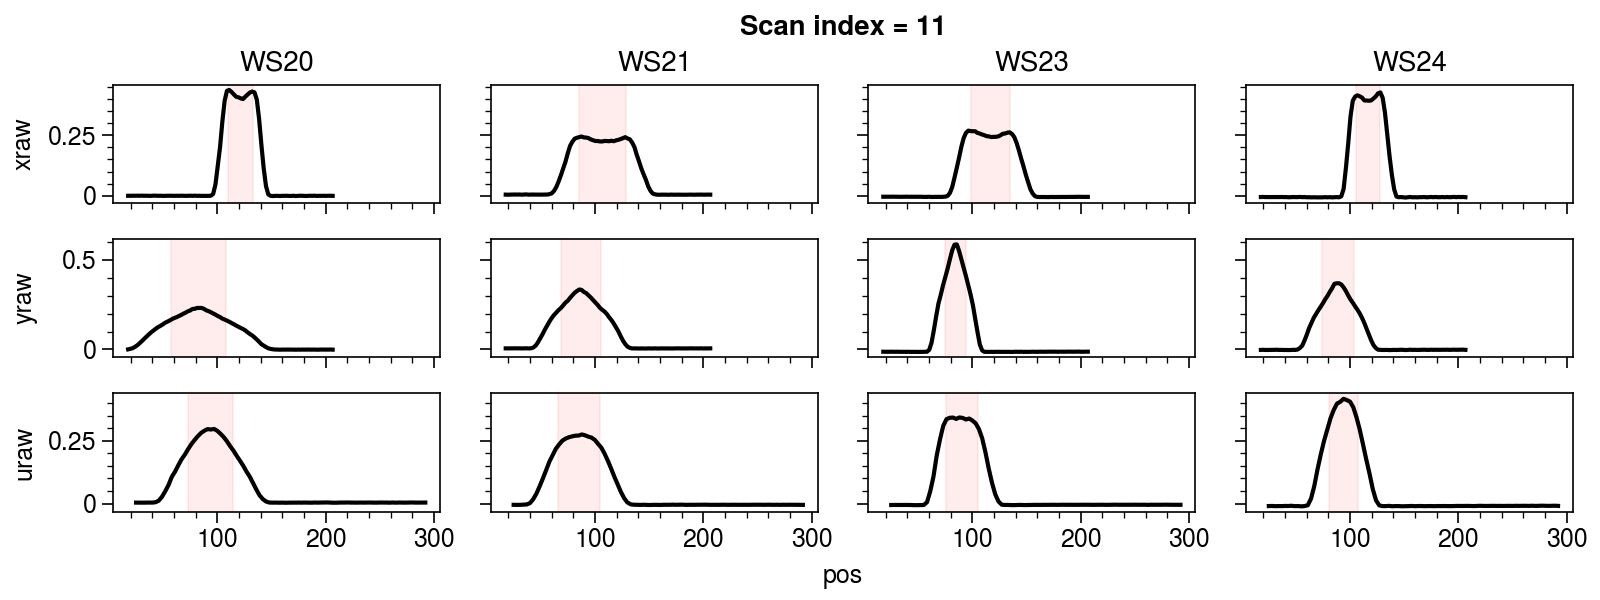

In [31]:
c1, c2 = 'red', 'blue'
alpha = 0.075

for scan_index, measurement in zip(scan_indices, measurements):
    fig, axes = plot.subplots(ncols=4, nrows=3, figsize=(8, 3), spany=False, aligny=True)
    for j, ws_id in enumerate(ws_ids):
        profile = measurement[ws_id]
        for i, dim in enumerate(['x', 'y', 'u']):
            ax = axes[i, j]
            ax.plot(profile.data[dim + 'pos'], profile.data[dim + 'raw'], c='k', label='profile')
            std, mean = profile.get_param('Sigma', dim), profile.get_param('Mean', dim)              
            ax.axvspan(mean - std, mean + std, color=c1, alpha=alpha)
    for ax, ws_id in zip(axes[0, :], ws_ids):
        ax.set_title(ws_id)
    axes.format(xlabel='pos', suptitle='Scan index = {}'.format(scan_index), grid=False)
    plt.show()
    print()

### Calculation of x-y correlation

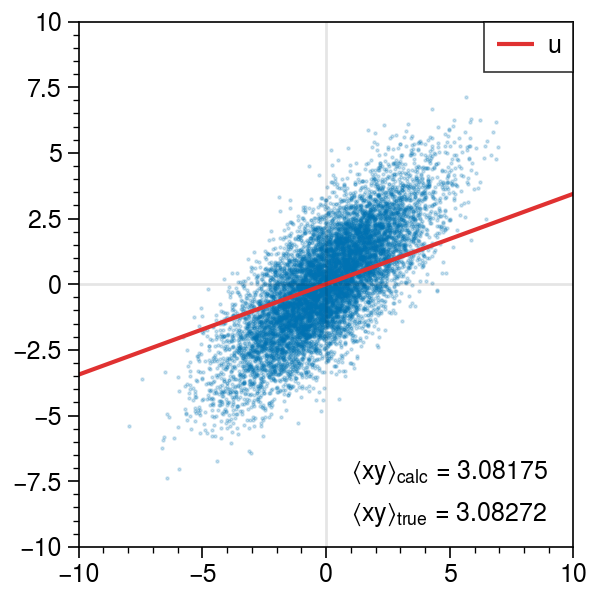

In [32]:
# Create distribution
X = np.random.multivariate_normal(mean=[0, 0], cov=[[4, 3], [3, 4]], size=10000)
Sigma = np.cov(X.T)
sig_xx, sig_yy, sig_xy = Sigma[0, 0], Sigma[1, 1], Sigma[0, 1]

# Project onto u axis
wire_angle = -np.radians(71.0)
phi = wire_angle + np.radians(90.0)
R = utils.rotation_matrix(phi)
Xrot = np.apply_along_axis(lambda row: np.matmul(R, row), 1, X)
sig_uu = np.var(Xrot[:, 0])

# Calculate cov(x, y) from projection
sig_xy_calc = get_sig_xy(sig_xx, sig_yy, sig_uu, wire_angle)

# Plot
fig, ax = plot.subplots(figsize=(3, 3))
ax.scatter(X[:, 0], X[:, 1], s=1, alpha=0.2, markeredgecolor=None)
ax.format(grid=False, xlim=(-10, 10), ylim=(-10, 10))
xvals = np.array(ax.get_xlim())
ax.plot(xvals, xvals * np.tan(phi), c='red8');
ax.axvline(0, c='k', alpha=0.1, zorder=99, lw=1)
ax.axhline(0, c='k', alpha=0.1, zorder=99, lw=1)
ax.annotate(r'$\langle{xy}\rangle_{calc}$ = ' + '{:.5f}'.format(sig_xy_calc), 
            xy=(0.55, 0.13), xycoords='axes fraction')
ax.annotate(r'$\langle{xy}\rangle_{true}$ = ' + '{:.5f}'.format(sig_xy), 
            xy=(0.55, 0.05), xycoords='axes fraction')
ax.legend(labels='u', handlelength=1.5);

## Conclusion

We at least got something somewhat reasonable using only a few scans. I'm going to make a simple GUI to speed things up (just to hit "set phases" instead of typing in terminal editor). I also realized from Jonathan's talk that the energy I used is about 40-50 MeV off (I used 1 GeV). Probably other things to talk about, but wanted to send this update. 